<a href="https://colab.research.google.com/github/surajnihal/breast-cancer-analysis/blob/main/datamodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Modeling with PCA Features

This notebook builds predictive models using PCA-transformed features from the Wisconsin Breast Cancer Diagnostic dataset.  
We’ll train and evaluate multiple classifiers to distinguish between malignant and benign tumors using a reduced feature set engineered from earlier EDA.

Dataset: `pca_data.csv`  
Target: `Diagnosis` (1 = Malignant, 0 = Benign)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [ ]:
# loading the pca dataset from the eda
pca_df = pd.read_csv('pca_data.csv')

# preview the data
print(pca_df.head())

   Contour_Shape  Fractal_Border  Texture_Smoothness  Texture_Intensity  \
0       9.192837        1.948583           -1.123166          -3.633731   
1       2.387802       -3.768172           -0.529293          -1.118264   
2       5.733896       -1.075174           -0.551748          -0.912083   
3       7.122953       10.275589           -3.232790          -0.152547   
4       3.935302       -1.948072            1.389767          -2.940639   

   Surface_Smoothness  Diagnosis  
0            1.195110          1  
1           -0.621775          1  
2            0.177086          1  
3            2.960878          1  
4           -0.546747          1  


In [ ]:
# checking the shape
pca_df.shape

(569, 6)

In [ ]:
# checking the datatypes
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contour_Shape       569 non-null    float64
 1   Fractal_Border      569 non-null    float64
 2   Texture_Smoothness  569 non-null    float64
 3   Texture_Intensity   569 non-null    float64
 4   Surface_Smoothness  569 non-null    float64
 5   Diagnosis           569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [ ]:
# the imbalance in target variable
pca_df['Diagnosis'].value_counts()

0    357
1    212
Name: Diagnosis, dtype: int64

### Handling Class Imbalance

The target variable `Diagnosis` is imbalanced — with more benign cases (`0`) than malignant (`1`).  
This imbalance can bias standard classifiers toward the majority class, reducing their ability to detect malignant tumors.

To address this, we apply **two strategies**:

#### 1. **Data-Level Strategy** – Resampling with SMOTE
We use **SMOTE** (Synthetic Minority Oversampling Technique) to generate synthetic samples of the minority class before training.  
This helps balance the dataset and improves sensitivity to malignant cases.

We apply SMOTE with the following models:
- **Logistic Regression (LR)**
- **Support Vector Classifier (SVC)**
- **Random Forest (RF)**

#### 2. **Algorithm-Level Strategy** – Built-in Class Imbalance Handling
Some ensemble methods are designed to handle imbalance internally, without the need for resampling:

- **Balanced Random Forest (BRF)** – adjusts sampling within each tree
- **Easy Ensemble (EE)** – trains multiple classifiers on balanced subsets and combines them


### Logistc Regression + SMOTE

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__C': 10.0}
Accuracy: 0.9737
ROC AUC Score: 0.9954

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Specificity: 0.9861


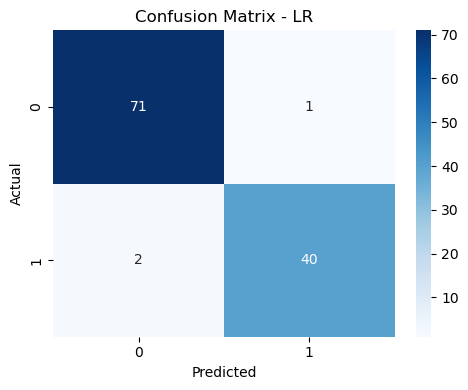

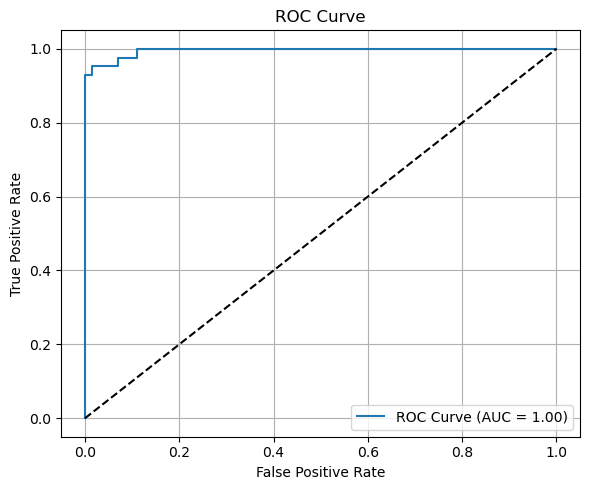

In [ ]:
from sklearn.linear_model import LogisticRegression

# Creating a new df
df = pca_df

# Split features and target
X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Define pipeline with SMOTE + scaling + Logistic Regression
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Define hyperparameter space
param_dist = {
    'clf__C': np.logspace(-3, 3, 10),
    'clf__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'],
    'clf__penalty': ['l2']  # 'l1' only supported by liblinear & saga
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)

# Fit the model
search.fit(X_train, y_train)

# Predict and evaluate
y_pred = search.best_estimator_.predict(X_test)
y_proba = search.best_estimator_.predict_proba(X_test)[:, 1]

# Metrics
print("\nBest Parameters:", search.best_params_)
print("Accuracy:", round(search.best_estimator_.score(X_test, y_test), 4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Specificity = TN / (TN + FP)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", round(specificity, 4))

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LR")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Logistic Regression Coefficients (on PCA components):
Contour_Shape         8.818487
Fractal_Border       -3.036300
Surface_Smoothness    1.478871
Texture_Intensity     1.002506
Texture_Smoothness   -0.486814
dtype: float64


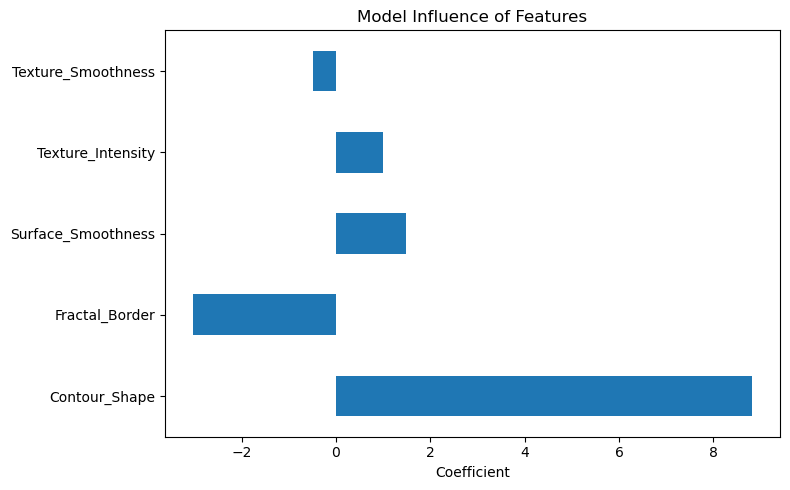

In [ ]:
# Extract the best model
best_model = search.best_estimator_.named_steps['clf']

# Get feature names and coefficients
coeffs = pd.Series(best_model.coef_[0], index=X.columns)
coeffs = coeffs.sort_values(key=abs, ascending=False)

print("Logistic Regression Coefficients (on PCA components):")
print(coeffs)


coeffs.plot(kind='barh', figsize=(8, 5), title="Model Influence of Features")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

### SVC (Type of SVM) + SMOTE

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters: {'clf__kernel': 'linear', 'clf__gamma': 'auto', 'clf__C': 35.93813663804626}
Accuracy: 0.9737
ROC AUC Score: 0.9957

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Specificity: 0.9861


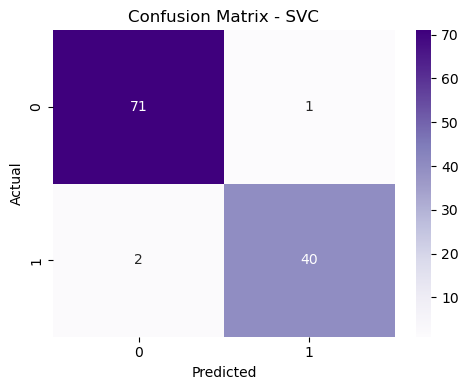

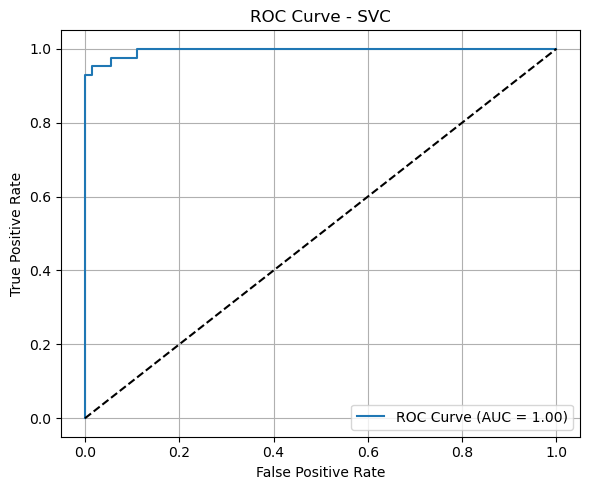

In [ ]:
from sklearn.svm import SVC

# Load the PCA dataset
df = pd.read_csv("pca_data.csv")

# Split features and target
X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Define pipeline with SMOTE + scaling + SVC
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True))  # Enable probability estimates for ROC
])

# Define hyperparameter space
param_dist = {
    'clf__C': np.logspace(-2, 2, 10),
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__gamma': ['scale', 'auto']
}


# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)

# Fit the model
search.fit(X_train, y_train)

# Predict and evaluate
y_pred = search.best_estimator_.predict(X_test)
y_proba = search.best_estimator_.predict_proba(X_test)[:, 1]

# Metrics
print("\nBest Parameters:", search.best_params_)
print("Accuracy:", round(search.best_estimator_.score(X_test, y_test), 4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Specificity = TN / (TN + FP)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", round(specificity, 4))

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Feature Influence (SVC - Linear Kernel):
Contour_Shape         6.502757
Fractal_Border       -2.386823
Surface_Smoothness    1.096423
Texture_Intensity     0.806545
Texture_Smoothness   -0.470344
dtype: float64


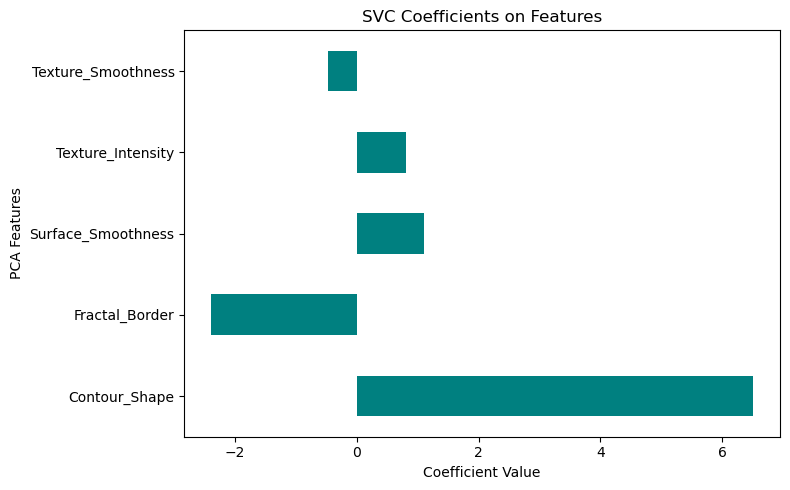

In [ ]:
# Get the trained SVC model from the pipeline
svc_model = search.best_estimator_.named_steps['clf']

# Map coefficients to feature names
svc_coeffs = pd.Series(svc_model.coef_[0], index=X.columns)

# Sort by absolute influence
svc_coeffs_sorted = svc_coeffs.sort_values(key=abs, ascending=False)

# Print coefficients
print("Feature Influence (SVC - Linear Kernel):")
print(svc_coeffs_sorted)

# Plot
plt.figure(figsize=(8, 5))
svc_coeffs_sorted.plot(kind='barh', color='teal')
plt.title("SVC Coefficients on Features")
plt.xlabel("Coefficient Value")
plt.ylabel("PCA Features")
plt.tight_layout()
plt.show()

### RF + SMOTE

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best Parameters: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
Accuracy: 0.9474
ROC AUC Score: 0.9944

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Specificity: 0.9722


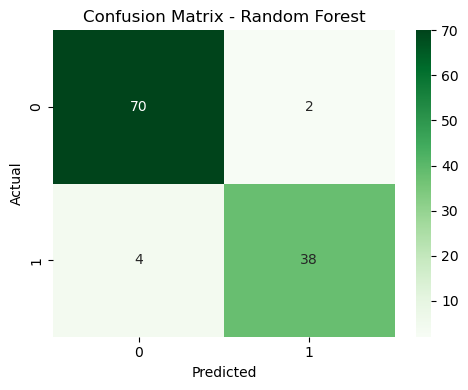

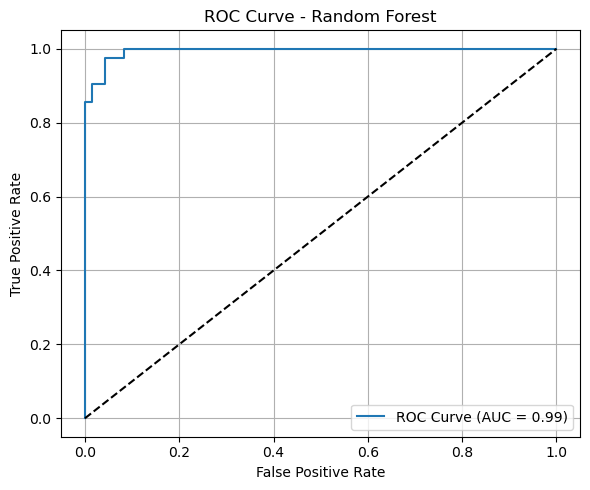

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv("pca_data.csv")

# Split features and target
X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Build pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Light hyperparameter search space
param_dist = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['log2', 'sqrt']
}

# Randomized Search with CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

# Predict and evaluate
y_pred = search.best_estimator_.predict(X_test)
y_proba = search.best_estimator_.predict_proba(X_test)[:, 1]

print("\nBest Parameters:", search.best_params_)
print("Accuracy:", round(search.best_estimator_.score(X_test, y_test), 4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", round(specificity, 4))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

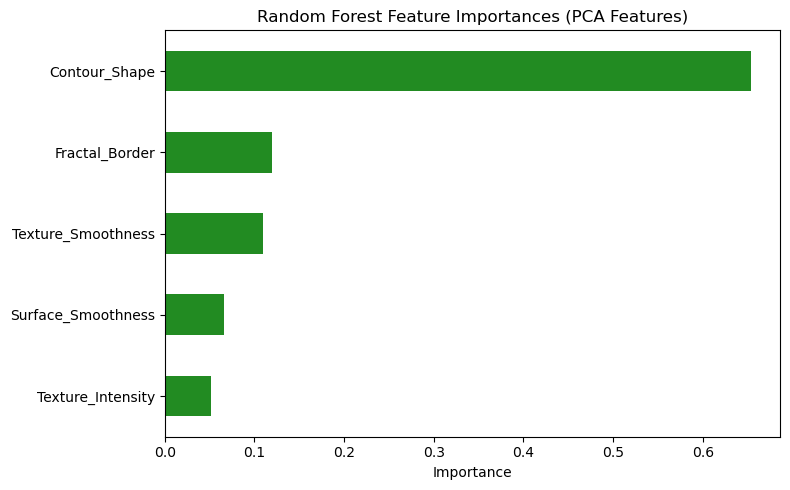

In [ ]:
# Feature Importance
rf_model = search.best_estimator_.named_steps['clf']
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.plot(kind='barh', color='forestgreen')
plt.title("Random Forest Feature Importances (PCA Features)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### BRF (No SMOTE)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 20}
Accuracy: 0.9386
ROC AUC Score: 0.9931

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        72
           1       0.93      0.90      0.92        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

Specificity: 0.9583


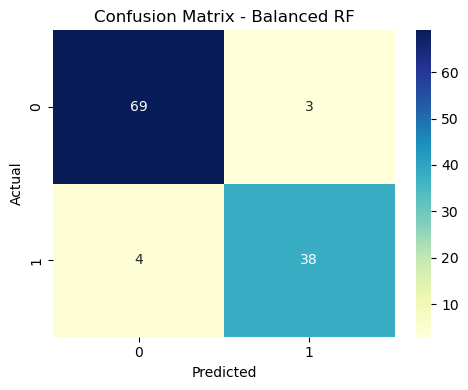

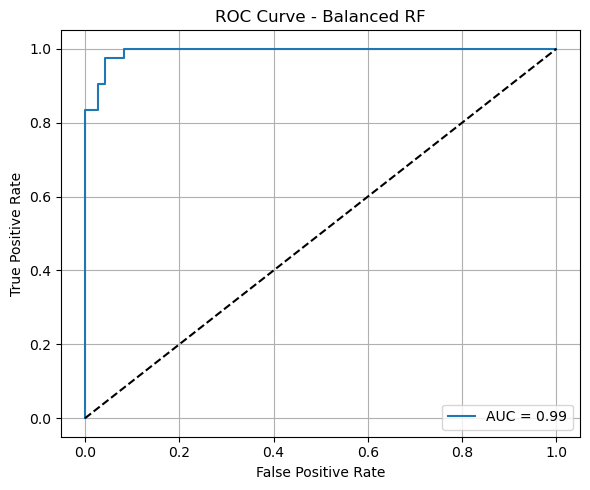

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Load PCA data
df = pd.read_csv("pca_data.csv")

# Split features and target
X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. Define model
brf = BalancedRandomForestClassifier(random_state=42)

# 5. Define light tuning grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['log2', 'sqrt']
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search
search = RandomizedSearchCV(
    brf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Train
search.fit(X_train, y_train)

# Predict
y_pred = search.best_estimator_.predict(X_test)
y_proba = search.best_estimator_.predict_proba(X_test)[:, 1]

# Metrics
print("Best Params:", search.best_params_)
print("Accuracy:", round(search.best_estimator_.score(X_test, y_test), 4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", round(specificity, 4))

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Balanced RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Balanced RF")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

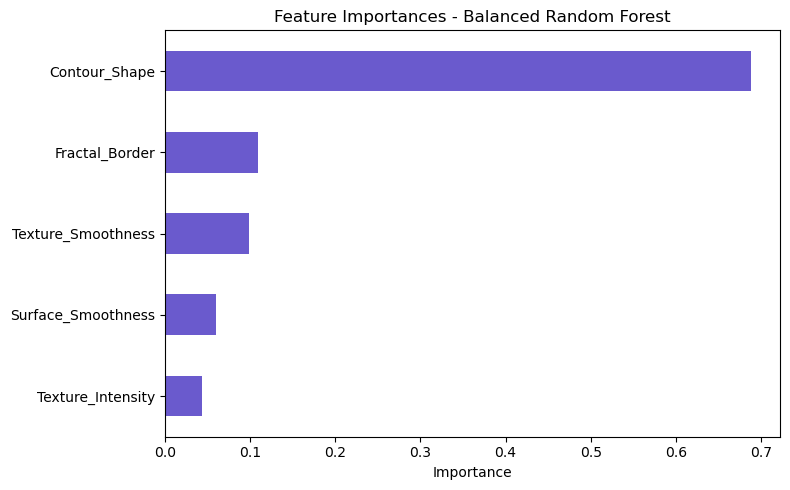

In [ ]:
# Feature Importance Plot
importances = pd.Series(search.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.plot(kind='barh', color='slateblue')
plt.title("Feature Importances - Balanced Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Easy Ensemble (No SMOTE)

/Users/surajnihal/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params: {'sampling_strategy': 'auto', 'n_estimators': 10}
Accuracy: 0.9474
ROC AUC Score: 0.9894

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Specificity: 0.9722


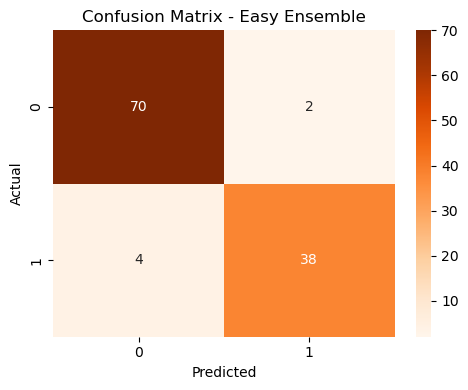

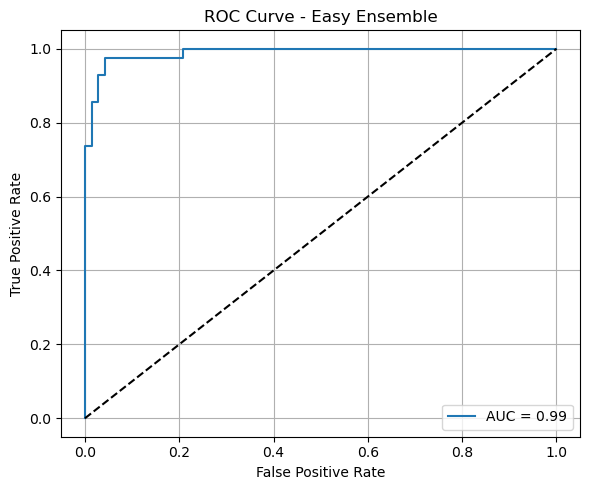

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier

# Load PCA data
df = pd.read_csv("pca_data.csv")

# Features and target
X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define model
eec = EasyEnsembleClassifier(random_state=42)

# Define hyperparameter grid (light)
param_dist = {
    'n_estimators': [10, 25, 50],
    'sampling_strategy': ['auto', 'not majority', 'all']
}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
search = RandomizedSearchCV(
    eec,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

# Predict and evaluate
y_pred = search.best_estimator_.predict(X_test)
y_proba = search.best_estimator_.predict_proba(X_test)[:, 1]

print("Best Params:", search.best_params_)
print("Accuracy:", round(search.best_estimator_.score(X_test, y_test), 4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", round(specificity, 4))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Easy Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Easy Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Results & Evaluation

For a detailed breakdown of model performance, please refer to the [results section of my Substack post](https://aixme.substack.com/p/breast-cancer-in-2025#:~:text=are%20the%20results..-,Results,-Before%20we%20jump).